In [160]:
import pandas as pd
from py_files import data_manager
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination
from matplotlib import pyplot as plt
import json

In [150]:
# load in feather file
final_df = pd.read_feather('data/play_by_play_full_state_space.feather')
final_df['WIN'] = final_df['home_score'] > final_df['away_score']
final_df = final_df[final_df['game_date'] >= '2018-10-01']
final_df = final_df[final_df['game_date'] < '2019-10-01']

In [167]:
for col in final_df.columns:
    print(col)

HOME_FACEOFF
STATE_SHOT_HOME
STATE_BLOCKED_SHOT_HOME
HOME_GIVEAWAY
HOME_HIT
STATE_MISSED_SHOT_HOME
HOME_TAKEAWAY
STATE_GOAL_HOME
HOME_PENALTY
HOME_TIME_REMAINING
HOME_HOME
HOME_WIN
HOME_TEAM
HOME_GAME_ID
HOME_CORSI
HOME_FENWICK
AWAY_FACEOFF
STATE_SHOT_AWAY
STATE_BLOCKED_SHOT_AWAY
AWAY_GIVEAWAY
AWAY_HIT
AWAY_MISSED_SHOT
AWAY_TAKEAWAY
STATE_GOAL_AWAY
AWAY_PENALTY
AWAY_TIME_REMAINING
AWAY_HOME
AWAY_WIN
AWAY_TEAM
AWAY_GAME_ID
AWAY_CORSI
AWAY_FENWICK
game_seconds_remaining
WIN
game_id
AWAY_CORSI_FOR
AWAY_FENWICK_FOR
HOME_CORSI_FOR
HOME_FENWICK_FOR
HOME_CHALLENGE
AWAY_CHALLENGE


In [161]:
final_df = pd.read_hdf('data/processed_data.h5', key='df')
final_df = final_df.rename(columns={'GAME_ID': 'game_id', 'HOME_GOAL':'STATE_GOAL_HOME', 'AWAY_GOAL':'STATE_GOAL_AWAY','HOME_SHOT':'STATE_SHOT_HOME', 'AWAY_SHOT':'STATE_SHOT_AWAY',
                                    'HOME_BLOCKED_SHOT':'STATE_BLOCKED_SHOT_HOME', 'AWAY_BLOCKED_SHOT':'STATE_BLOCKED_SHOT_AWAY', 'HOME_MISSED_SHOT':'STATE_MISSED_SHOT_HOME','TIME_REMAINING':'game_seconds_remaining'})

with open('team_colors.json') as f:
        team_colors = json.load(f)

In [164]:
# take the last two season
df = final_df.copy()

label_column = 'WIN'

game_groups = df.groupby('game_id')

game_ids = df.game_id.unique()

train_ids, test_ids = train_test_split(game_ids, test_size=0.2, random_state=42)

train = df[df.game_id.isin(train_ids)]
test = df[df.game_id.isin(test_ids)]

keepers = [
    "game_id",
    "STATE_GOAL_HOME",
    "STATE_GOAL_AWAY",
    "STATE_SHOT_HOME",
    "STATE_SHOT_AWAY",
    "STATE_BLOCKED_SHOT_HOME",
    "STATE_BLOCKED_SHOT_AWAY",
    "game_seconds_remaining",
    "WIN",
]

train = train[keepers]

model_dict = [('STATE_GOAL_HOME', 'WIN'), ('STATE_GOAL_AWAY', 'WIN')]
model_dict.extend([('game_seconds_remaining', 'STATE_SHOT_HOME'), ('game_seconds_remaining', 'STATE_SHOT_AWAY')])
model_dict.extend([('STATE_SHOT_HOME', 'STATE_GOAL_HOME'), ('STATE_SHOT_AWAY', 'STATE_GOAL_AWAY')])
model_dict.extend([('STATE_BLOCKED_SHOT_HOME', 'STATE_GOAL_AWAY'), ('STATE_BLOCKED_SHOT_AWAY', 'STATE_GOAL_HOME')])
model_dict.extend([('STATE_SHOT_HOME', 'STATE_BLOCKED_SHOT_AWAY'), ('STATE_SHOT_AWAY', 'STATE_BLOCKED_SHOT_HOME')])

# Define the structure of the Bayesian network
model = BayesianNetwork(model_dict)

# Learn the parameters of the Bayesian network using Maximum Likelihood Estimation
model.fit(train, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/327 [00:00<?, ?it/s]

100%|██████████| 327/327 [00:03<00:00, 101.78it/s]


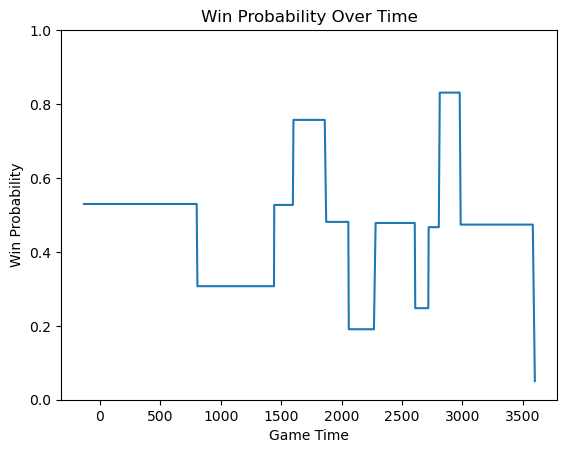

Final State
Home Score: 5
Away Score: 6


In [198]:
# pick a random game to train on from test
# game_id = np.random.choice(test.game_id.unique())
game_id = 2018020129

game_to_test = test[test.game_id == game_id]
prob_array = np.zeros((len(game_to_test), 2))

# reset index 
game_to_test = game_to_test.reset_index(drop=True)
time_remaining = []

# loop through game to test
for index, row in tqdm(game_to_test.iterrows(), total=len(game_to_test)):
    # get the row
    row = row.to_frame().T

    home_team = row['HOME_TEAM'].values[0]
    away_team = row['AWAY_TEAM'].values[0]
    home_team = list(team_colors.keys())[int(home_team)]
    away_team = list(team_colors.keys())[int(away_team)]

    # get color by index
    home_color = team_colors[home_team]
    away_color = team_colors[away_team]

    # get the game state
    game_state = row[keepers]

    # get the game state
    game_state = game_state.drop(columns=['game_id', 'WIN'])
    time_remaining.append(row['game_seconds_remaining'])

    inference = VariableElimination(model)

    # Define the evidence
    evidence = game_state.to_dict(orient='records')[0]

    # Perform inference to compute posterior probabilities
    posterior_probabilities = inference.query(variables=['WIN'], evidence=evidence)

    # Extract probabilities of each outcome
    home_team_win_probability = posterior_probabilities.values[1]

    # add the win probability to the array
    prob_array[index, :] = home_team_win_probability

# plot the win probability
plt.ylim(0, 1)
plt.plot(time_remaining[::-1], prob_array[:, 1])
plt.xlabel('Game Time')
plt.ylabel('Win Probability')
plt.title('Win Probability Over Time')
plt.show()

# print final state
away_goals = int(game_state['STATE_GOAL_AWAY'].values[0])
home_goals = int(game_state['STATE_GOAL_HOME'].values[0])
time_remaining = np.array(time_remaining)[::-1].squeeze()
prob_array = prob_array[:, 1]
print('Final State')
print('Home Score:', int(home_goals))
print('Away Score:', int(away_goals))

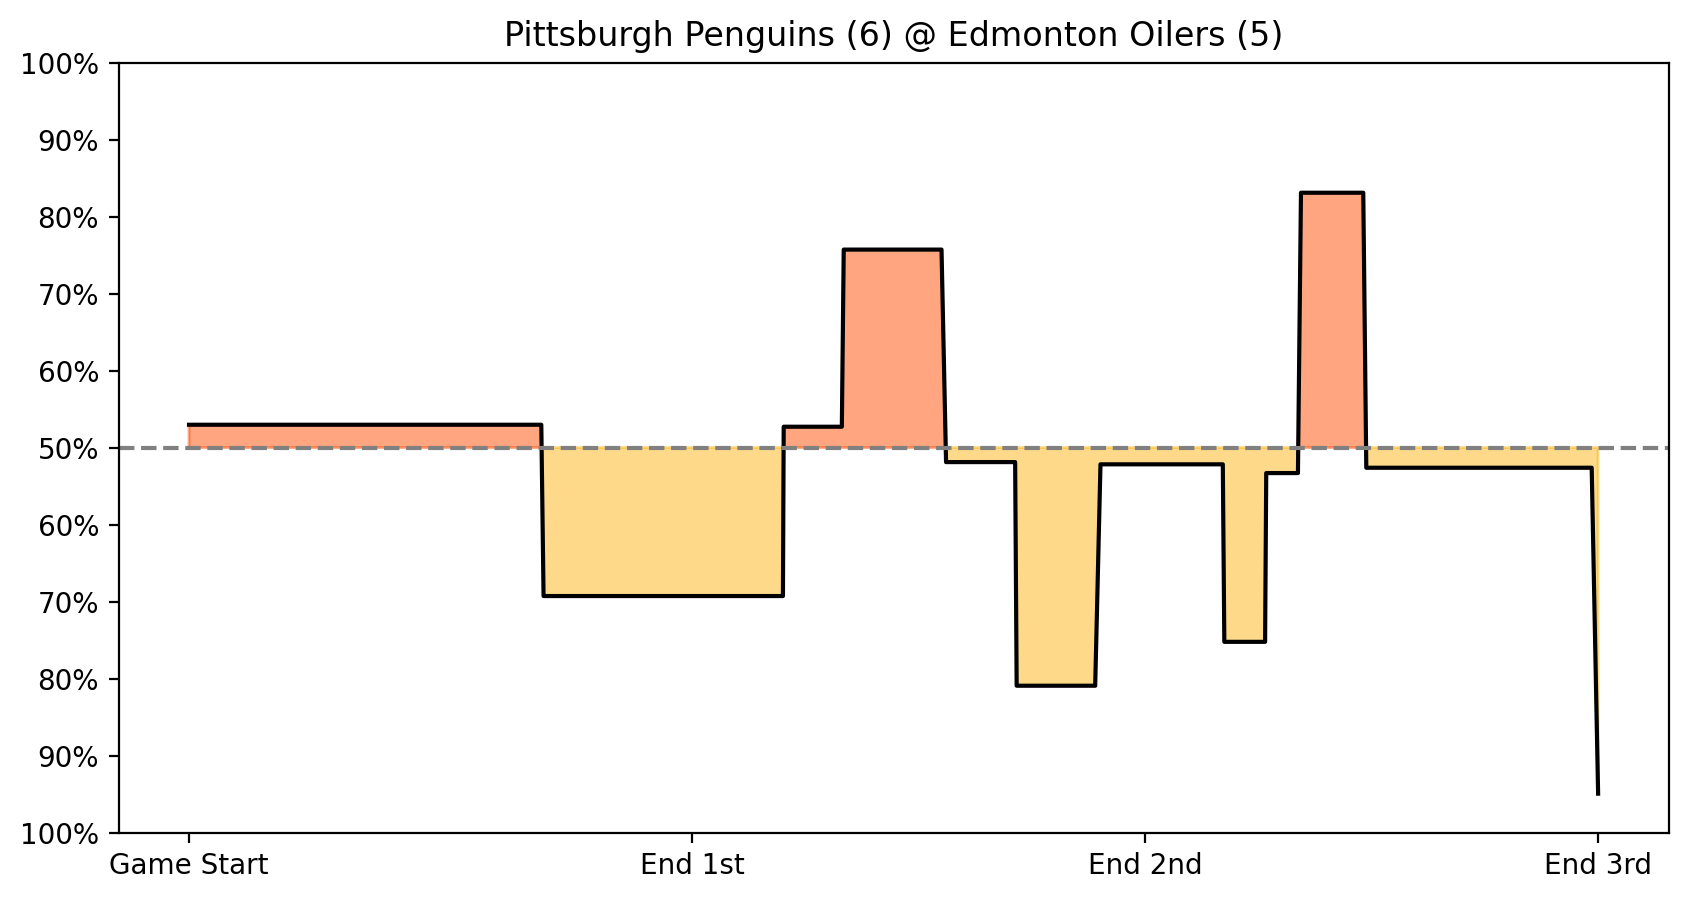

In [203]:
# Set threshold
threshold = 0.5


# Plot the probabilities
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(time_remaining, prob_array, color='black')

# Fill area above 50% with blue for Home Team
plt.fill_between(time_remaining, threshold, prob_array, where=prob_array >= threshold, color=home_color['main'], interpolate=True, alpha=0.5)

# Fill area below 50% with red for Home Team
plt.fill_between(time_remaining, threshold, prob_array, where=prob_array < threshold, color=away_color['main'], interpolate=True, alpha=0.5)

# Add a dotted horizontal line at y = 0.5
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.yticks(ticks=[0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], labels=['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

# Plot when the goal was scored
# mask = (game_data.curr_goals.shift(-1) != game_data.curr_goals).values
# mask[-1] = False
# opp_mask = (game_data.curr_opponent_goals.shift(-1) != game_data.curr_opponent_goals).values
# opp_mask[-1] = False
# team_goals = game_data[mask]['game_seconds']
# opp_goals = game_data[opp_mask]['game_seconds']
# home_goals = team_goals if home_team == team else opp_goals
# away_goals = team_goals if home_team == opp else opp_goals
# plt.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
# plt.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

# Plot periods
# plt.vlines([1200, 2400, 3600], 0, 1, color='black', linestyle='-', label='Period End')
plt.xticks(ticks=[min(time_remaining), 1200, 2400, 3600], labels=['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
plt.title(f'{away_team} ({away_goals}) @ {home_team} ({home_goals})')
plt.savefig('good_bayesian_example.png')
# plt.legend()

# Show plot
plt.show()

In [132]:
good_game_ids = []

In [201]:
good_game_ids.append(game_id)

In [197]:
good_game_ids

[2018020129, 2018021245, 2018020847]

In [108]:
inference = VariableElimination(model)

# Define the evidence
# evidence = game_state.to_dict(orient='records')[0]
evidence = {}
evidence['STATE_GOAL_HOME'] = 4
evidence['STATE_GOAL_AWAY'] = 4

# Perform inference to compute posterior probabilities
posterior_probabilities = inference.query(variables=['WIN'], evidence=evidence)

# Extract probabilities of each outcome
home_team_win_probability = posterior_probabilities.values[1]
away_team_win_probability = posterior_probabilities.values[0]

print("Probability of Home Team Win:", home_team_win_probability)
print("Probability of Away Team Win:", away_team_win_probability)

Probability of Home Team Win: 0.46687054026503566
Probability of Away Team Win: 0.5331294597349643
